## <i>Reprojecting Geographic Data
    ### This notebook reprjects ookla broadband data from it's original quadkey geometries across Florida census tract geometries for mapping.
### Michelle Ide, GitHub mishide / DataKind project "Broadband Access" Sept 23 2021


#### GEOID is an 11 digit combination of 3 codes: 
    # (2) FIPS code which is the state, Florida is 12
    # (3) County Code
    # (6) Tract ID, the first value of the tract ID from the census bureau is 'T'.

#### There are:   --67 Counties in Florida  -- 4245 Census Tracts

## Import Libraries

In [1]:
# Import all libraries for this notebok
%matplotlib inline

  # data libraries
import numpy as np   
import pandas as pd

  # visualization libraries
import matplotlib
import matplotlib.pyplot as plt

  # data extraction from ookla
from datetime import datetime

  # geometry libraries
import geopandas as gp
from shapely.geometry import Point
from adjustText import adjust_text

## Collect Data
    # Extract Ookla Data for Q1 year 2021
    # Extract Census Tract Geo Data from Census Bureau

In [2]:
# Functions to set datetime format (quarter_start) & extract ookla shape data (get_shapes)

"""code referenced: https://github.com/teamookla/ookla-open-data/blob/master/tutorials/aggregate_by_county_py.ipynb"""

def quarter_start(year: int, q: int) -> datetime:                  # Convert to datetime
    if not 1 <= q <= 4:
        raise ValueError("Quarter must be within [1, 2, 3, 4]")

    month = [1, 4, 7, 10]
    return datetime(year, month[q - 1], 1)

def get_shapes(service_type: str, year: int, q: int) -> str:       # Get shape files by year and quarter
    dt = quarter_start(year, q)

    base_url = "https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance"
    url = f"{base_url}/type%3D{service_type}/year%3D{dt:%Y}/quarter%3D{q}/{dt:%Y-%m-%d}_performance_fixed_tiles.zip"
    return url

In [3]:
# Get the ookla data url for 2021 1st and 2nd quarters

q3_url = get_shapes("fixed", 2020, 3)
q4_url = get_shapes("fixed", 2020, 4)
q1_url = get_shapes("fixed", 2021, 1)
q2_url = get_shapes("fixed", 2021, 2)

In [4]:
# read in the shape files

q3_ookla = gp.read_file(q3_url)
q4_ookla = gp.read_file(q4_url)
q1_ookla = gp.read_file(q1_url)
q2_ookla = gp.read_file(q2_url)

# label quarters
q1_ookla['quarter'] = "1"
q2_ookla['quarter'] = "2"
q3_ookla['quarter'] = "3"
q4_ookla['quarter'] = "4"

In [5]:
# combine  2 quarters of ookla data

tiles = gp.GeoDataFrame(pd.concat([q1_ookla,q2_ookla, q3_ookla, q4_ookla]))

In [6]:
# read in tract geometries from census bureau

tract_url = "https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_12_tract.zip"  
fl_tracts = gp.read_file(tract_url)

In [7]:
# filter for Florida and reproject to match the tiles

tracts_fl = fl_tracts.loc[fl_tracts['STATEFP'] == '12'].to_crs(4326)

## Re-project ookla 'tiles' using geopandas sjoin where ookla intersects census 'tracts_fl'

In [8]:
"""A spatial join uses binary predicates such as intersects and crosses to combine 
two GeoDataFrames based on the spatial relationship between their geometries."""

tiles_in_fl_tracts = gp.sjoin(tiles, tracts_fl, how="inner", op='intersects')

In [9]:
# convert to Mbps

tiles_in_fl_tracts['avg_d_mbps'] = tiles_in_fl_tracts['avg_d_kbps'] / 1000
tiles_in_fl_tracts['avg_u_mbps'] = tiles_in_fl_tracts['avg_u_kbps'] / 1000

## Aggregate by average download speed - weighted by number of tests

In [10]:
tract_stats = (
    tiles_in_fl_tracts.groupby(["GEOID", "NAMELSAD"])
    .apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])}
        )
    )
    .reset_index()
    .merge(
        tiles_in_fl_tracts.groupby(["GEOID", "NAMELSAD"])
        .agg(tests=("tests", "sum"))
        .reset_index(),
        on=["GEOID", "NAMELSAD"],
    )
)

## Merge the tract geometry with the aggregated tract data

In [11]:
# Merge the census geometry with the ookla data

tract_data = tracts_fl[['GEOID', 'geometry']].merge(tract_stats, on='GEOID').to_crs(26916)

## Bin the download speeds for easy reading

In [12]:
# 6 bins indicating average download speeds

labels = ["0 to 5 Mbps", "5 to 25", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]

tract_data['group'] = pd.cut(
    tract_data.avg_d_mbps_wt, 
    (0, 5, 25, 50, 100, 150, 200), 
    right=False, 
    labels = labels
)

## Add some top Florida city labels

In [13]:
# add place labels 

fl_places = gp.read_file("ftp://ftp2.census.gov/geo/tiger/TIGER2019/PLACE/tl_2019_12_place.zip")

In [14]:
# filter for major metropolitin city (PCICBSA == Y)

fl_places = fl_places.loc[fl_places['PCICBSA'] >= "Y"].sample(15, random_state=1).to_crs(26916)
fl_places["centroid"] = fl_places["geometry"].centroid
fl_places.set_geometry("centroid", inplace = True)

## Plot the map

1

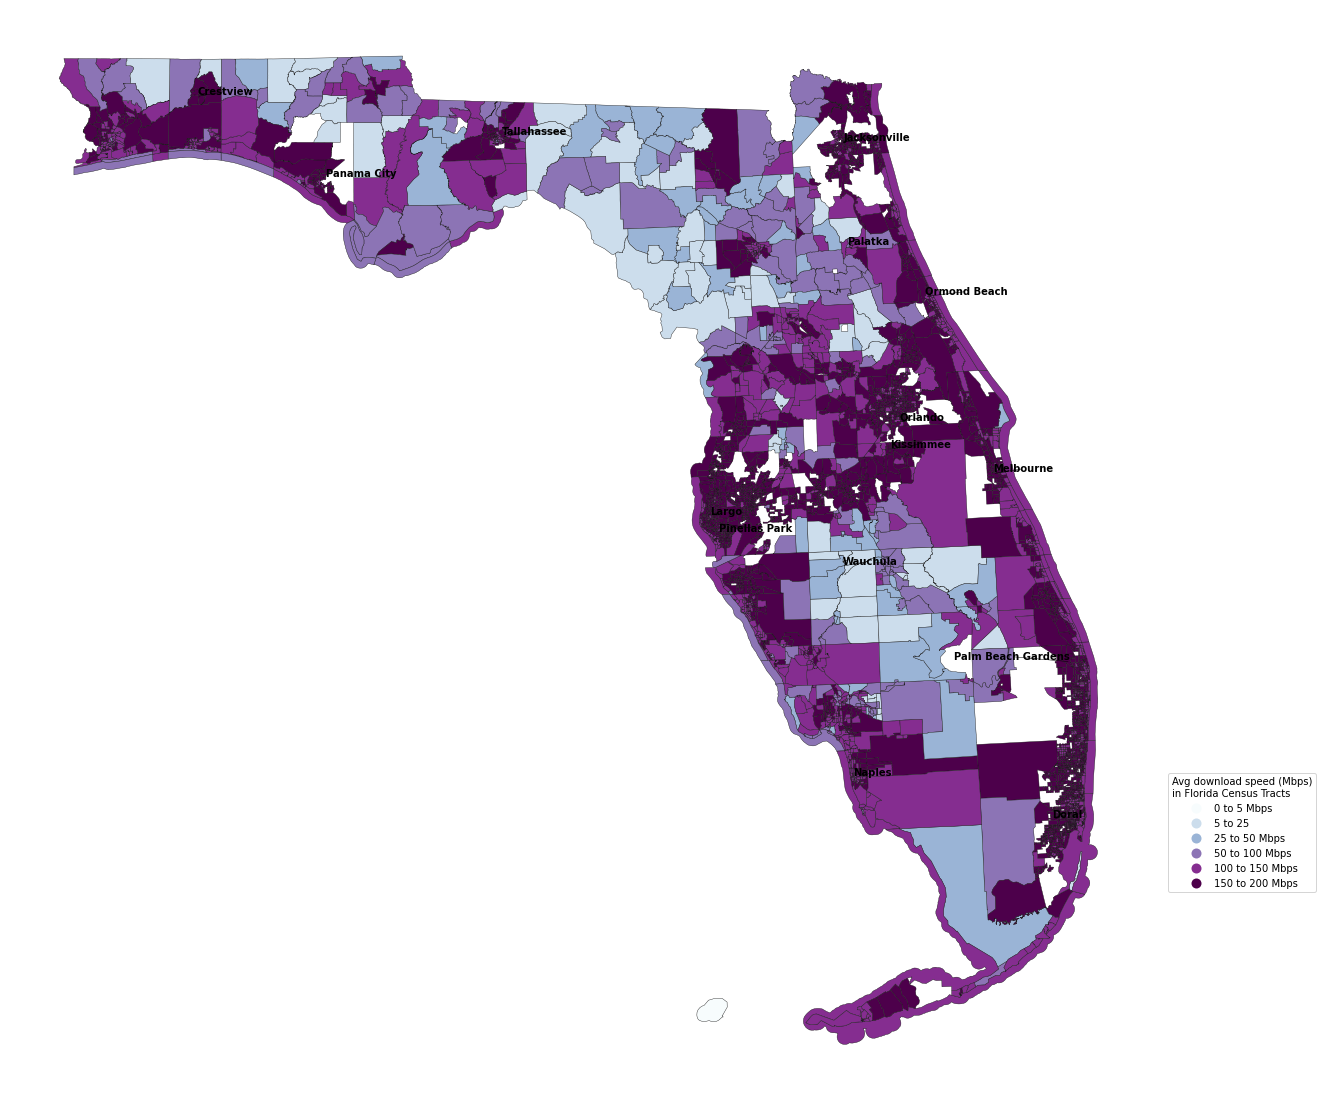

In [15]:
# Map plots Florida Census tracts indicating average download speeds for each

fig, ax = plt.subplots(1, figsize=(40, 20))

tract_data.plot(
    column="group", cmap="BuPu", linewidth=0.4, ax=ax, edgecolor="0.1", legend=True
)

ax.axis("off")

leg = ax.get_legend()
leg.set_bbox_to_anchor((1.15, 0.3))
leg.set_title("Avg download speed (Mbps)\nin Florida Census Tracts")

texts = []
for x, y, label in zip(fl_places.geometry.x, fl_places.geometry.y, fl_places["NAME"]):
    texts.append(plt.text(x, y, label, fontsize=10, fontweight="bold", ha="left"))

adjust_text(
    texts,
    force_points=0.3,
    force_text=0.8,
    expand_points=(1, 1),
    expand_text=(1, 1),
    arrowprops=dict(arrowstyle="-", color="black", lw=0.5),
)